In [55]:
import numpy as np
import tensorflow as tf
import os
import cv2
import imghdr
import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

data_dir = 'data'
image_exts = ['jpg', 'jpeg', 'png']

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in exts list {}'.format(image_path))
                print('Tip: {}'.format(tip))
                os.remove(image_path)
        except Exception as e:
            print('Image {} is corrupted. Removing it.'.format(image_path))
            os.remove(image_path)

Image not in exts list data\cats\hand-stroking-petting-tabby-cat-1200x628-facebook-1200x628.jpg
Tip: None


Found 546 files belonging to 2 classes.


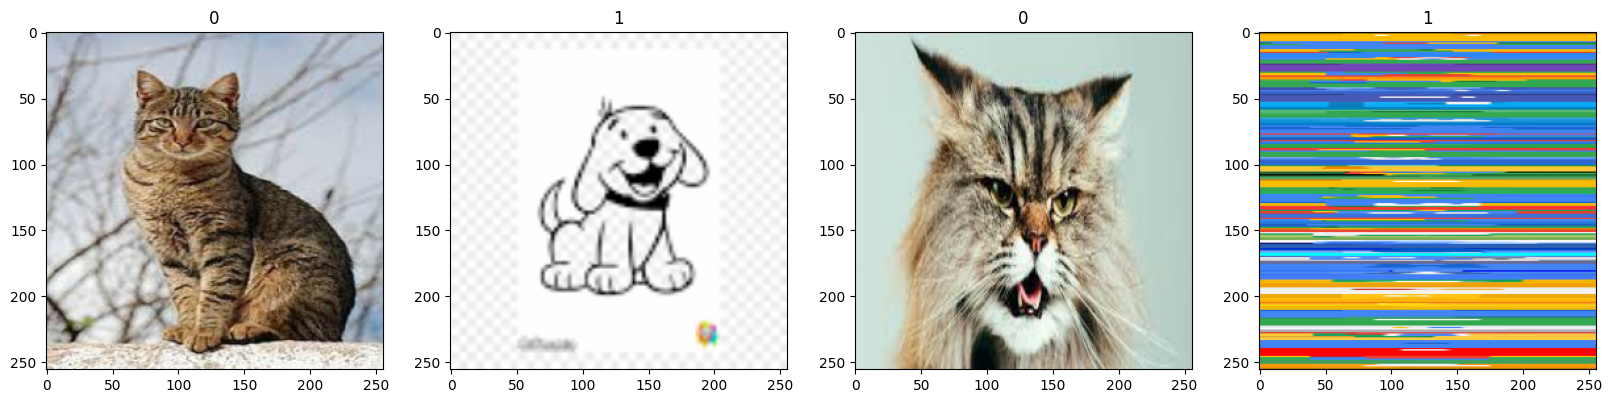

In [57]:
data = tf.keras.utils.image_dataset_from_directory('data', batch_size=32, image_size=(256, 256))

scaled_data = data.map(lambda x, y: (x / 255, y))
scaled_iterator = scaled_data.as_numpy_iterator()
batch = scaled_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [58]:
train_size = int(len(scaled_data) * 0.7)
val_size = int(len(scaled_data) * 0.2) + 1
test_size = int(len(scaled_data) * 0.1) + 1

train_data = scaled_data.take(train_size)
test_data = scaled_data.skip(train_size).take(test_size)
val_data = scaled_data.skip(train_size + val_size).take(test_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), 1, activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (3, 3), 1, activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 30, 30, 16)       

Epoch 1/20
12/12 [==============================] - 10s 669ms/step - loss: 1.1838 - accuracy: 0.5495 - val_loss: 0.7229 - val_accuracy: 0.4412
Epoch 2/20
12/12 [==============================] - 7s 553ms/step - loss: 0.6814 - accuracy: 0.5599 - val_loss: 0.6640 - val_accuracy: 0.6471
Epoch 3/20
12/12 [==============================] - 7s 543ms/step - loss: 0.6550 - accuracy: 0.5521 - val_loss: 0.6774 - val_accuracy: 0.5588
Epoch 4/20
12/12 [==============================] - 7s 594ms/step - loss: 0.6316 - accuracy: 0.6276 - val_loss: 0.5233 - val_accuracy: 0.7353
Epoch 5/20
12/12 [==============================] - 9s 710ms/step - loss: 0.6221 - accuracy: 0.6849 - val_loss: 0.5671 - val_accuracy: 0.7353
Epoch 6/20
12/12 [==============================] - 10s 840ms/step - loss: 0.5895 - accuracy: 0.6693 - val_loss: 0.5802 - val_accuracy: 0.8529
Epoch 7/20
12/12 [==============================] - 8s 672ms/step - loss: 0.5371 - accuracy: 0.7292 - val_loss: 0.5283 - val_accuracy: 0.7941
Epoc

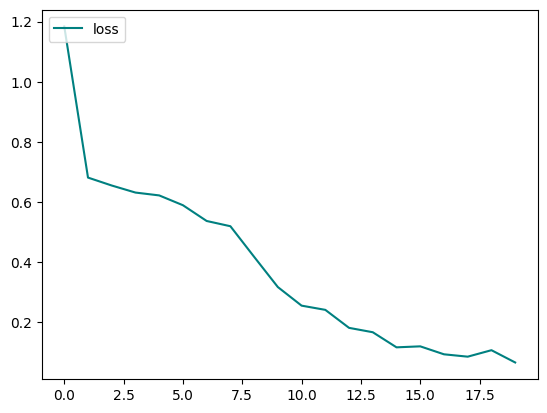

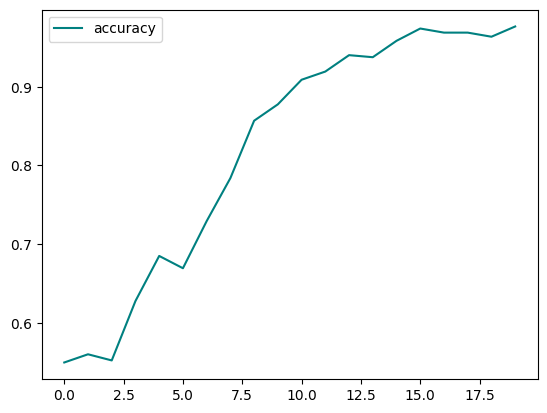

In [59]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)
history = model.fit(train_data, epochs=20, validation_data=val_data, callbacks=[tensorboard_callback])

plt.plot(history.history['loss'], color='teal', label='loss')
plt.legend(loc='upper left')
plt.show()

plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.legend(loc='upper left')
plt.show()

In [60]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.BinaryAccuracy()

In [61]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

print(
    f'Precision: {precision.result().numpy()}, Recall: {recall.result().numpy()}, Accuracy: {accuracy.result().numpy()}')

1/1 [==============================] - 0s 199ms/step
Precision: 1.0, Recall: 1.0, Accuracy: 1.0


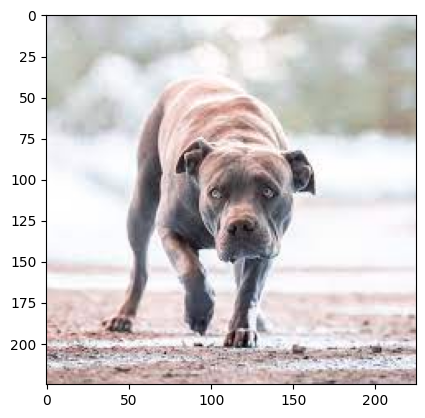

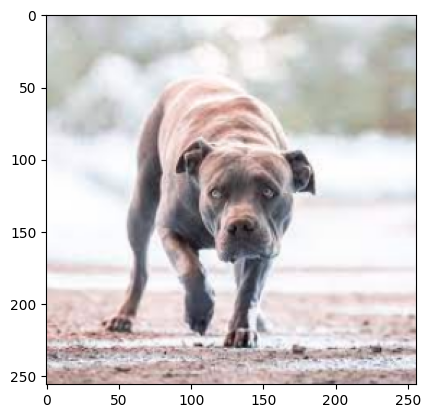

In [84]:
img = cv2.imread('data_test/dogtest.jpeg')
plt.imshow(img)
plt.show()

resized_img = tf.image.resize(img, (256, 256))
plt.imshow(resized_img.numpy().astype(int))
plt.show()

In [85]:
import numpy as np

yhat = model.predict(np.expand_dims(resized_img / 255, 0))
print('{}'.format('Is good boy' if yhat > 0.5 else 'Is Pépito'))

1/1 [==============================] - 0s 31ms/step
Is good boy


In [86]:
model.save(os.path.join('models', 'dog_or_cat_classifier_model.h5'))
new_model = tf.keras.models.load_model(os.path.join('models', 'dog_or_cat_classifier_model.h5'))

C:\Users\sergi\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [87]:
# Ensure that the saved model is working as expected
# Result should be te same as above
new_yhat = model.predict(np.expand_dims(resized_img / 255, 0))
print('{}'.format('Is good boy' if new_yhat > 0.5 else 'Is Pépito'))

1/1 [==============================] - 0s 31ms/step
Is good boy
